# This Anime Character Doesnt Exist - DCGAN




### What is GAN ?
In generative models, we were always trying to estimate the data distribution by maximum likelihood approach. But in GAN we'll use a whole different approach.
In this approach we have a generative network (as we had before) and we have an extra network called "Discriminator". The discriminator's duty is to recognize fake and real images from each other. The objective for the discriminator is:
$$\text{argmax}_{\theta} \, \mathbb{E}_{x \sim p_{data}} \log[\mathbf{D}_{\theta}(x)] + \mathbb{E}_{x \sim p_{G_{\phi}}} \log[1-\mathbf{D}_{\theta}(x)]$$
And the objective function for generative is:
$$ \text{argmin}_{\phi} \mathbb{E}_{x \sim p_{data}} \log[\mathbf{D}_{\theta}(x)] + \mathbb{E}_{x \sim p_{G_{\phi}}} \log[1-\mathbf{D}_{\theta}(x)] = \text{argmin}_{\phi} \mathbb{E}_{x \sim p_{G_{\phi}}} \log[1-\mathbf{D}_{\theta}(x)]  $$
But I assume that you are enough familiar with GAN where you are seeing this notebook.<br/>
So we won't go on details on GAN. We'll refer you to related papers for each topic.

### Whats is DCGAN?
A DCGAN is a direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively.<br/>
In the paper Unsupervised <a href="https://arxiv.org/pdf/1511.06434.pdf">Representation Learning With Deep Convolutional Generative Adversarial Networks</a>. The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution. The generator is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations. The input is a latent vector, z
, that is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image. In the paper, the authors also give some tips about how to setup the optimizers, how to calculate the loss functions, and how to initialize the model weights, all of which will be explained in the coming sections. <br/>
We'll implement the model based on <a href="https://arxiv.org/pdf/1511.06434.pdf">this mian paper</a>.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import tarfile

tar = tarfile.open('./drive/My Drive/anime dataset/anime-faces.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [5]:
from __future__ import print_function
import os
import time
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np
import datetime

print('SETUP DONE')

SETUP DONE


In [16]:
################## Properties ##################

data_root = './anime-faces'
nc = 3
batch_size = 512
images_size = 64
nz = 100
ngf = ndf = 64
num_epochs = 30
lr = 0.0002
beta1 = 0.5
ngpu = 1
n_extra_g = 1
print_every = 250
device = torch.device('cuda:0')

#### Dataset 
In this tutorial we will use the <a href="https://pan.baidu.com/s/1o8Nxllo">anime-faces</a> dataset which has more than 115k images. <br/>

In the below cell, You'll see some examples of this dataset.

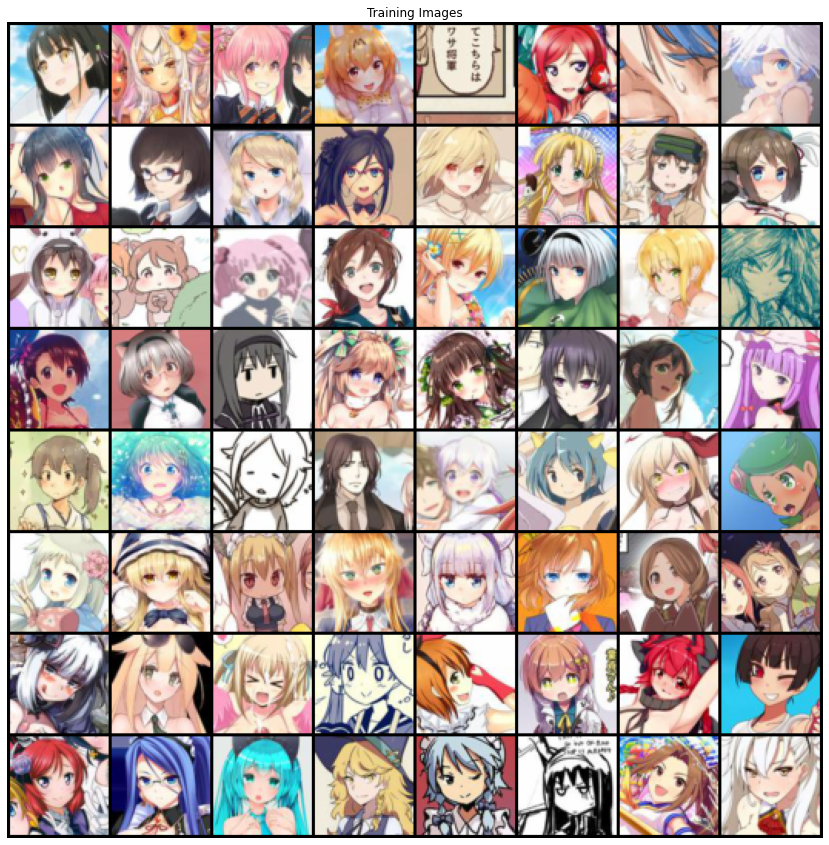

In [15]:
dataset = dset.ImageFolder(
    root=data_root,
    transform=transforms.Compose([
            transforms.Resize(images_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)


real_batch = next(iter(dataloader))
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Model Implementation

#### Weight Initialization

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The **weights_init** function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria.

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

#### Generator Network

The generator, G, is designed to map the latent space vector (z) to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of [−1,1]. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

![Generator based on DCGAN paper](https://i.ibb.co/4fx39zW/dcgan-generator.png)

In [18]:
class Generator(nn.Module):
    '''
        The model implementation will be exactly as is described in the paper.
    '''
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

#### Discriminator

As mentioned, the discriminator, $\mathbb D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, $\mathbb D$ takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both G and D.

In [19]:
class Discriminator(nn.Module):
    '''
        The model implementation will be exactly as is described in the paper.
    '''
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [20]:
### Instantiate the models ###

netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

#### Loss Functions and Optimizers
With D and G setup, we can specify how they learn through the loss functions and optimizers. We will use the Binary Cross Entropy loss (BCELoss) function.Next, we define our real label as 1 and the fake label as 0. These labels will be used when calculating the losses of D and G, and this is also the convention used in the original GAN paper.<br/>
Finally, we set up two separate optimizers, one for D and one for G. As specified in the DCGAN paper, both are Adam optimizers with learning rate 0.0002 and Beta1 = 0.5.

In [21]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

#### Training

##### **Train the Discriminator**
The goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake.
Due to the separate mini-batch suggestion from ganhacks, we will calculate this in two steps. First, we will construct a batch of real samples from the training set, forward pass through D, calculate the loss $\log(D(x))$, then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through D, calculate the loss $\log(1−D(G(z)))$, and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.



##### **Train the Generator**

As stated in the original paper, we want to train the Generator by minimizing $\log(1−D(G(z)))$ in an effort to generate better fakes. As mentioned, this was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize $\log(D(G(z)))$. In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss using real labels as GT, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step.

In [22]:
img_list = []
G_losses = []
D_losses = []
iters = 0
prev_time = time.time()

for epoch in range(num_epochs):
    for i, (img, _) in enumerate(dataloader, 0):
        ############################
        #  Update D network
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        real_data = img.to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, device=device)

        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()

        ############################
        # Update G network
        ###########################

        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)

        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # Output training stats
        if i % print_every == 0:
            batches_done = epoch * len(dataloader) + i
            batches_left = num_epochs * len(dataloader) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t ETA: %s'
                % (epoch, num_epochs, i, len(dataloader),
                    errD.item(), errG.item(), time_left))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/30][0/225]	Loss_D: 1.6773	Loss_G: 4.1160	 ETA: 3:51:24.376109
[1/30][0/225]	Loss_D: 0.6140	Loss_G: 3.3727	 ETA: 30 days, 22:09:26.924626
[2/30][0/225]	Loss_D: 0.3286	Loss_G: 5.1686	 ETA: 29 days, 20:34:55.958591
[3/30][0/225]	Loss_D: 0.3180	Loss_G: 5.1373	 ETA: 28 days, 20:13:45.331646
[4/30][0/225]	Loss_D: 0.8993	Loss_G: 7.6587	 ETA: 27 days, 17:49:40.926204
[5/30][0/225]	Loss_D: 0.9392	Loss_G: 2.2147	 ETA: 26 days, 15:26:51.597455
[6/30][0/225]	Loss_D: 0.3708	Loss_G: 5.7714	 ETA: 25 days, 14:07:43.319206
[7/30][0/225]	Loss_D: 0.4083	Loss_G: 3.8096	 ETA: 24 days, 17:36:17.204901
[8/30][0/225]	Loss_D: 0.3049	Loss_G: 4.9206	 ETA: 23 days, 17:57:29.440527
[9/30][0/225]	Loss_D: 0.3403	Loss_G: 4.2461	 ETA: 22 days, 15:58:28.605230
[10/30][0/225]	Loss_D: 0.5188	Loss_G: 3.3227	 ETA: 21 days, 11:33:19.257445
[11/30][0/225]	Loss_D: 0.3355	Loss_G: 4.3625	 ETA: 20 days, 6:30:54.866731
[12/30][0/225]	Loss_D: 0.5552	Loss_G: 0.9606	 ETA: 19 days, 5:17:39.869742
[13/30][0/225]	Loss_D: 0.6681	Loss

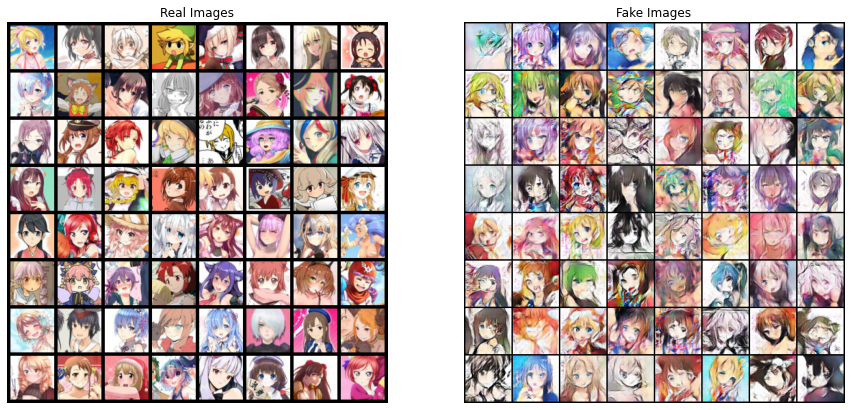

In [23]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

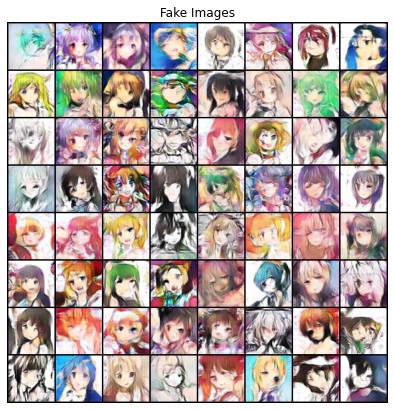

In [25]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-2],(1,2,0)))
plt.show()

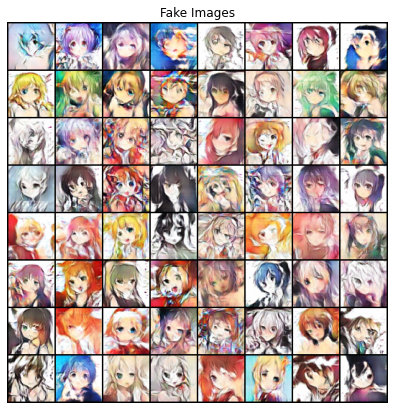

In [26]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-3],(1,2,0)))
plt.show()

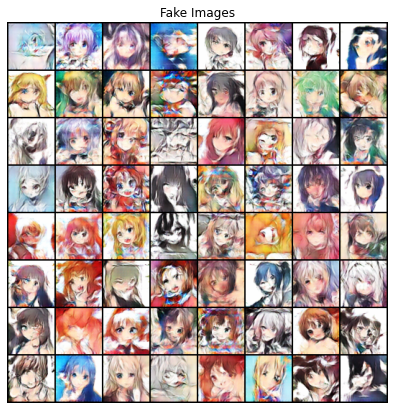

In [27]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-4],(1,2,0)))
plt.show()